In [17]:
import networkx as nx
import community
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
cluster = pd.read_csv('../data/topic_clusters.csv')

In [6]:
def preprocess_for_network(cluster_df):
    # Convert string representations to actual lists/dicts
    cluster_df = cluster_df.copy()
    cluster_df['unique_keywords'] = cluster_df['unique_keywords'].apply(eval)
    cluster_df['temporal_evolution'] = cluster_df['temporal_evolution'].apply(eval)
    cluster_df['sample_topics'] = cluster_df['sample_topics'].apply(eval)
    return cluster_df

In [7]:
cluster_processed = preprocess_for_network(cluster)

In [44]:
def create_semantic_network(cluster_df, min_similarity=0.2):
    """Create network based on semantic and temporal similarity"""
    G = nx.Graph()
    
    # Add nodes
    for idx, row in cluster_df.iterrows():
        G.add_node(row['cluster_id'],
                  keywords=row['unique_keywords'],
                  posts=row['total_posts'],
                  temporal=row['temporal_evolution'])
    
    def calculate_similarity(node1, node2):
        # Get node data
        kw1 = set(G.nodes[node1]['keywords'])
        kw2 = set(G.nodes[node2]['keywords'])
        temp1 = G.nodes[node1]['temporal']
        temp2 = G.nodes[node2]['temporal']
        
        # Keyword similarity (Jaccard)
        keyword_sim = len(kw1 & kw2) / len(kw1 | kw2) if len(kw1 | kw2) > 0 else 0
        
        # Temporal overlap
        shared_years = set(temp1.keys()) & set(temp2.keys())
        if not shared_years:
            return 0, 0, 0, []
        
        # Calculate temporal similarity
        temporal_sim = 0
        for year in shared_years:
            ratio = min(temp1[year], temp2[year]) / max(temp1[year], temp2[year])
            temporal_sim += ratio
        temporal_sim = temporal_sim / len(shared_years)
        
        # Combined similarity
        combined_sim = 0.7 * keyword_sim + 0.3 * temporal_sim
        
        return combined_sim, keyword_sim, temporal_sim, list(shared_years)
    
    # Calculate similarities and add edges
    nodes = list(G.nodes())
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            node1, node2 = nodes[i], nodes[j]
            
            combined_sim, kw_sim, temp_sim, shared_years = calculate_similarity(node1, node2)
            
            if combined_sim > min_similarity:
                G.add_edge(node1, node2, 
                          weight=combined_sim,
                          keyword_sim=kw_sim,
                          temporal_sim=temp_sim,
                          shared_years=shared_years)
    
    print(f"Created network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    print(f"Network density: {nx.density(G):.3f}")
    return G

In [45]:
G = create_semantic_network(cluster_processed)

Created network with 77 nodes and 711 edges
Network density: 0.243


In [20]:
G.number_of_nodes(), G.number_of_edges()

(77, 943)

In [52]:
def visualize_network(G, cluster_df, min_edge_weight=0.3):
    plt.figure(figsize=(20, 20))
    
    # Use spring layout with adjusted parameters
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Prepare node attributes
    node_sizes = []
    node_colors = []
    node_labels = {}
    post_counts = []  # Store actual post counts for legend
    
    for node in G.nodes():
        # Get post count
        posts = cluster_df[cluster_df['cluster_id'] == node]['total_posts'].iloc[0]
        post_counts.append(posts)
        
        # Size based on log of post count for better scaling
        size = 1000 * np.log1p(posts/100)  # Adjusted scaling
        node_sizes.append(size)
        
        # Color based on main year
        temporal = cluster_df[cluster_df['cluster_id'] == node]['temporal_evolution'].iloc[0]
        main_year = max(temporal.items(), key=lambda x: x[1])[0]
        node_colors.append(int(main_year))
        
        # Create clearer labels
        keywords = cluster_df[cluster_df['cluster_id'] == node]['unique_keywords'].iloc[0]
        node_labels[node] = f"C{node}\n{', '.join(keywords[:2])}"
    
    # Draw edges with weight-based transparency
    edges = G.edges(data=True)
    edge_weights = [d['weight'] for _, _, d in edges]
    
    # Filter edges by weight for clarity
    significant_edges = [(u, v) for u, v, d in edges if d['weight'] >= min_edge_weight]
    edge_colors = ['gray' if (u, v) in significant_edges else 'lightgray' for u, v, _ in edges]
    
    nx.draw_networkx_edges(G, pos, 
                          edgelist=list(edges),
                          edge_color=edge_colors,
                          width=[w*2 for w in edge_weights],
                          alpha=0.3)
    
    # Draw nodes
    nodes = nx.draw_networkx_nodes(G, pos,
                                 node_size=node_sizes,
                                 node_color=node_colors,
                                 cmap=plt.cm.viridis,
                                 alpha=0.7)
    
    # Add labels with better positioning
    for node, (x, y) in pos.items():
        # Scale font size with node size
        font_size = max(8, min(12, np.log1p(node_sizes[list(G.nodes()).index(node)]/100)))
        plt.text(x, y, node_labels[node],
                fontsize=font_size,
                ha='center', va='center',
                bbox=dict(facecolor='white', 
                         alpha=0.7,
                         edgecolor='none',
                         boxstyle='round,pad=0.5'))
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis,
                              norm=plt.Normalize(vmin=2020, vmax=2023))
    plt.colorbar(sm, label='Main Year')
    
    # Add title
    plt.title('Topic Cluster Network\n' +
             f'{G.number_of_nodes()} nodes, {G.number_of_edges()} edges\n' +
             'Node size: Total posts, Color: Main year, Edge width: Similarity',
             pad=20, fontsize=14)
    
    # Add legend for node sizes using actual post counts
    legend_posts = [min(post_counts), 
                   int(np.median(post_counts)), 
                   max(post_counts)]
    legend_sizes = [1000 * np.log1p(p/100) for p in legend_posts]
    
    legend_elements = [plt.scatter([], [], s=s,
                                 c='gray', alpha=0.7,
                                 label=f'{p:,} posts')
                      for s, p in zip(legend_sizes, legend_posts)]
    
    plt.legend(handles=legend_elements,
              title='Post Counts',
              loc='upper left',
              bbox_to_anchor=(1.1, 1))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

C:\Users\ch8765\AppData\Local\Temp\ipykernel_19232\4114446087.py:67: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



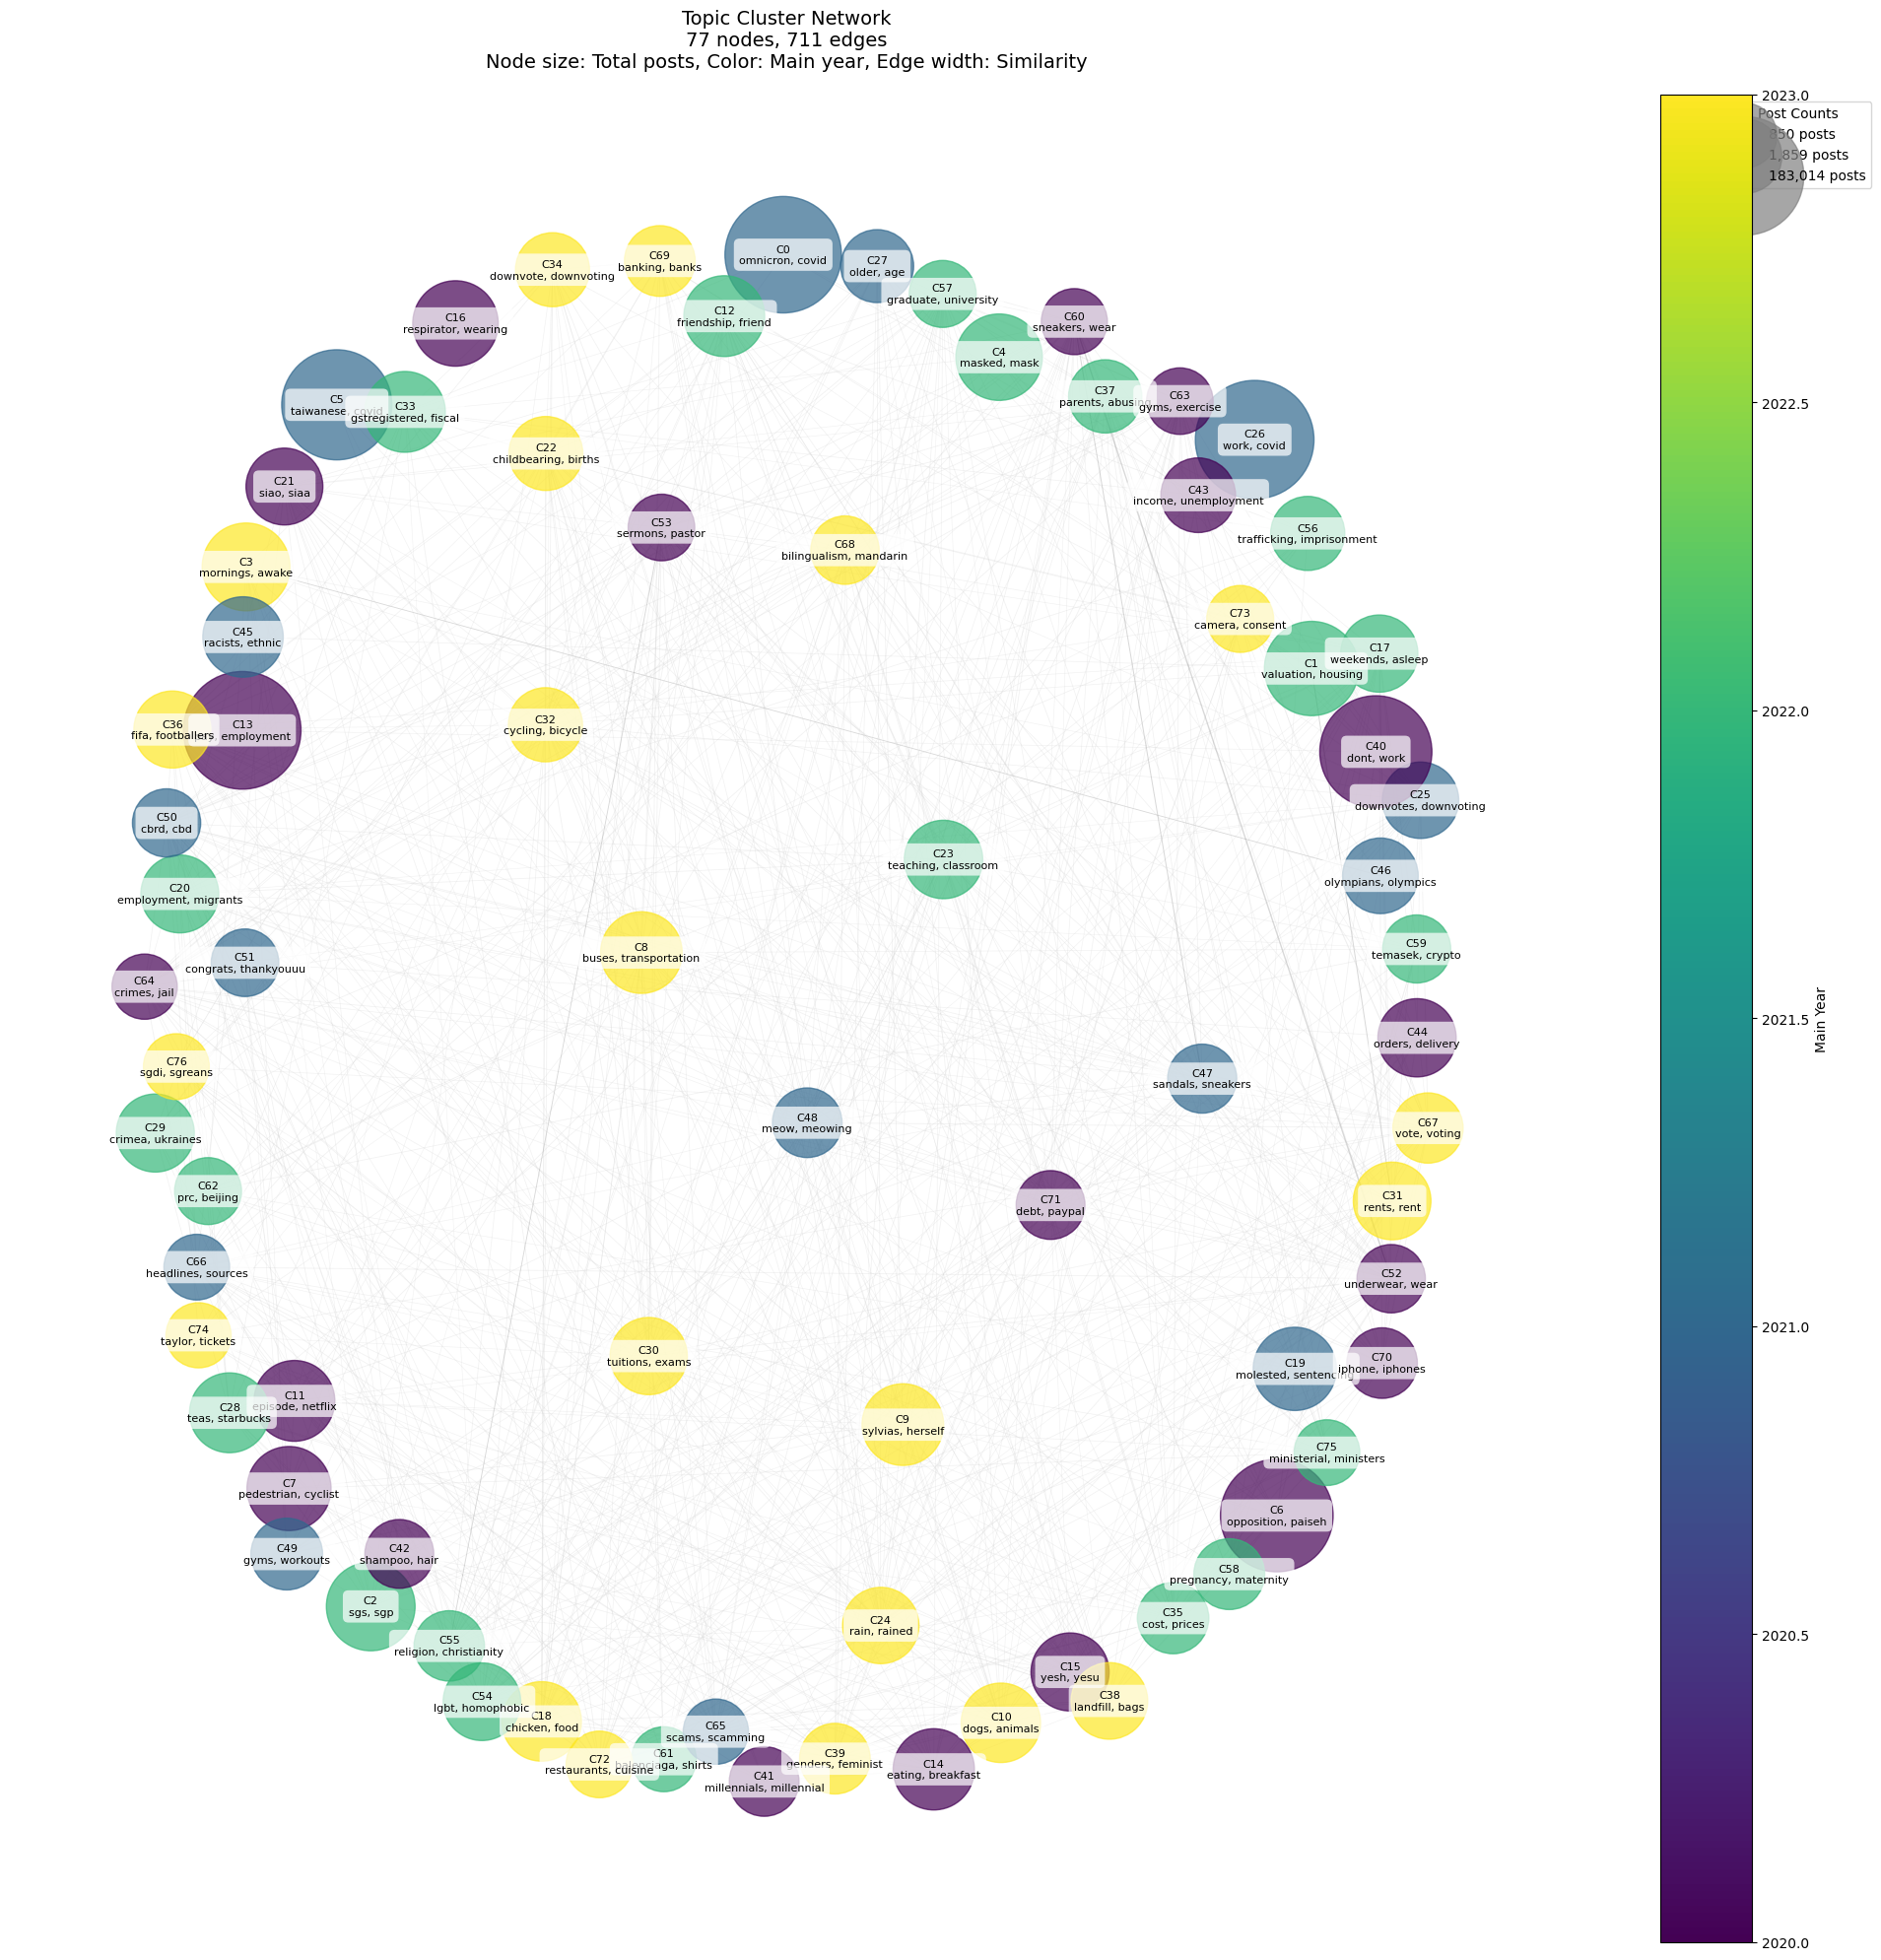

In [53]:
visualize_network(G, cluster_processed, min_edge_weight=0.3)

In [46]:
def analyze_network(G, cluster_df):
    """Analyze network structure and relationships"""
    print("\nNetwork Analysis:")
    
    # Calculate centrality measures
    try:
        eigen_centrality = nx.eigenvector_centrality(G, weight='weight')
        print("\nMost central clusters:")
        for node, score in sorted(eigen_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
            keywords = cluster_df[cluster_df['cluster_id'] == node]['unique_keywords'].iloc[0]
            posts = cluster_df[cluster_df['cluster_id'] == node]['total_posts'].iloc[0]
            print(f"Cluster {node}: {', '.join(keywords[:3])} ({posts:,} posts) - Score: {score:.3f}")
    except:
        print("Could not calculate eigenvector centrality (possibly due to network structure)")
    
    # Analyze connections
    print("\nMost meaningful cluster relationships:")
    edges = [(u, v, d) for u, v, d in G.edges(data=True)]
    for u, v, d in sorted(edges, key=lambda x: x[2]['weight'], reverse=True)[:5]:
        kw1 = cluster_df[cluster_df['cluster_id'] == u]['unique_keywords'].iloc[0]
        kw2 = cluster_df[cluster_df['cluster_id'] == v]['unique_keywords'].iloc[0]
        print(f"\nConnection strength: {d['weight']:.3f}")
        print(f"Keyword similarity: {d['keyword_sim']:.3f}")
        print(f"Temporal similarity: {d['temporal_sim']:.3f}")
        print(f"Cluster {u}: {', '.join(kw1[:3])}")
        print(f"Cluster {v}: {', '.join(kw2[:3])}")
        print(f"Shared years: {sorted(d['shared_years'])}")
    
    # Community detection
    if G.number_of_edges() > 0:
        communities = nx.community.louvain_communities(G)
        print(f"\nCommunity Analysis ({len(communities)} communities detected):")
        
        for idx, community in enumerate(sorted(communities, key=len, reverse=True)[:3]):
            print(f"\nCommunity {idx+1} (Size: {len(community)})")
            print("Key clusters:")
            for node in community:
                row = cluster_df[cluster_df['cluster_id'] == node].iloc[0]
                print(f"  Cluster {node}: {', '.join(row['unique_keywords'][:3])} ({row['total_posts']:,} posts)")
    
    # Basic network metrics
    print("\nNetwork Metrics:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Network density: {nx.density(G):.3f}")
    if G.number_of_edges() > 0:
        print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
        print("\nDegree Statistics:")
        degrees = [d for n, d in G.degree()]
        print(f"Average degree: {sum(degrees)/len(degrees):.2f}")
        print(f"Maximum degree: {max(degrees)}")


In [47]:
analyze_network(G, cluster_processed)


Network Analysis:

Most central clusters:
Cluster 52: underwear, wear, attire (1,110 posts) - Score: 0.224
Cluster 53: sermons, pastor, churches (967 posts) - Score: 0.213
Cluster 48: meow, meowing, meoww (1,230 posts) - Score: 0.207
Cluster 50: cbrd, cbd, cb2 (1,099 posts) - Score: 0.200
Cluster 60: sneakers, wear, attire (925 posts) - Score: 0.191

Most meaningful cluster relationships:

Connection strength: 0.489
Keyword similarity: 0.375
Temporal similarity: 0.754
Cluster 52: underwear, wear, attire
Cluster 60: sneakers, wear, attire
Shared years: ['2020']

Connection strength: 0.363
Keyword similarity: 0.111
Temporal similarity: 0.951
Cluster 47: sandals, sneakers, shoe
Cluster 60: sneakers, wear, attire
Shared years: ['2020']

Connection strength: 0.360
Keyword similarity: 0.100
Temporal similarity: 0.967
Cluster 1: valuation, housing, flats
Cluster 31: rents, rent, tenancy
Shared years: ['2023']

Connection strength: 0.319
Keyword similarity: 0.100
Temporal similarity: 0.832
Cl